<a href="https://colab.research.google.com/github/Derrick-Majani/Engineering_College_K-Means/blob/main/K_Means_EngineeringCollege_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Engineering Colleges Case Study

## Context

Education is fast becoming a very competitive sector with hundreds of institutions to choose from. It is a life-transforming experience for any student and it has to be a thoughtful decision. There are ranking agencies that do a survey of all the colleges to provide more insights to students. Agency RankForYou wants to leverage this year's survey to roll out an editorial article in leading newspapers, on the state of engineering education in the country. Head of PR (Public Relations) comes to you, the data scientist working at RankForYou, and asks you to come up with evidence-based insights for that article.

## Objective

To identify different types of engineering colleges in the country to better understand the state of affairs.


## Key Questions

- How many different types (clusters/segments) of colleges can be found from the data?
- How do these different groups of colleges differ from each other?
- Do you get slightly different solutions from two different techniques? How would you explain the difference?


## Data Description

The data contains survey results for 26 engineering colleges. The initial survey data has been summarized into a rating scale of 1-5 for different factors.

**Factor rating index**
 - 1 - Very low
 - 2 - Low
 - 3 - Medium
 - 4 - High
 - 5 - Very high
 
**Data Dictionary**
 - SR_NO: Serial Number
 - Engg_College: 26 Engineering colleges with pseudonyms A to Z
 - Teaching: Quality of teaching at the engineering college
 - Fees: Fees at the engineering college
 - Placements: Job placements after a student graduates from the engineering college
 - Internship: Student Internships at the engineering college
 - Infrastructure: Infrastructure of the engineering college

## Let's start coding!

### Importing necessary libraries

In [1]:
# this will help in making the Python code more structured automatically (good coding practice)


# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd
import io

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler

# to compute distances
from scipy.spatial.distance import cdist

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

In [2]:
# Use Local drives to upload the excel on google colab
from google.colab import files
uploaded = files.upload()

Saving Engineering Colleges Case Study.xlsx to Engineering Colleges Case Study.xlsx


In [4]:
# loading the dataset

data = pd.read_excel(io.BytesIO(uploaded['Engineering Colleges Case Study.xlsx']))

In [5]:
data.shape

(26, 7)

* The dataset has 26 rows and 7 columns 

In [7]:
# viewing a random sample of the dataset
data.sample(n=10, random_state=1)

,SR_NO,Engg_College,Teaching,Fees,Placements,Internship,Infrastructure
18,19,S,3,5,4,3,3
13,14,N,3,5,3,3,4
17,18,R,3,4,4,3,3
3,4,D,5,4,5,4,4
22,23,W,2,5,1,1,1
10,11,K,3,4,3,4,5
19,20,T,3,5,3,2,3
20,21,U,2,2,2,2,1
4,5,E,2,5,2,2,5
2,3,C,4,5,5,4,5


In [8]:
# copying the data to another variable to avoid any changes to original data
df = data.copy()

In [9]:
# dropping the serial no. column as it does not provide any information
df.drop("SR_NO", axis=1, inplace=True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Engg_College    26 non-null     object
 1   Teaching        26 non-null     int64 
 2   Fees            26 non-null     int64 
 3   Placements      26 non-null     int64 
 4   Internship      26 non-null     int64 
 5   Infrastructure  26 non-null     int64 
dtypes: int64(5), object(1)
memory usage: 1.3+ KB


**Observations**

- *Engg_College* is a categorical variable with 26 levels that indicate each college's name.
- The 5 rating variables are of type *int* (integer).

In [11]:
df.describe()

,Teaching,Fees,Placements,Internship,Infrastructure
count,26.000000,26.000000,26.000000,26.000000,26.000000
mean,2.807692,3.576923,2.884615,2.769231,3.384615
std,1.132051,1.331858,1.531716,1.242826,1.298520
min,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,2.250000,1.250000,2.000000,3.000000
50%,3.000000,4.000000,3.000000,2.000000,3.000000
75%,3.000000,5.000000,4.000000,4.000000,4.750000
max,5.000000,5.000000,5.000000,5.000000,5.000000


**Observations**

- The median value of fees is 4, indicating that most of the engineering colleges have high fees.
- The mean and median of other ratings lie between 2 and 3, except the mean infrastructure rating.

In [12]:
# checking for missing values
df.isna().sum()

Engg_College      0
Teaching          0
Fees              0
Placements        0
Internship        0
Infrastructure    0
dtype: int64

- There are no missing values in our data

# EDA

### Univariate Analysis

In [13]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

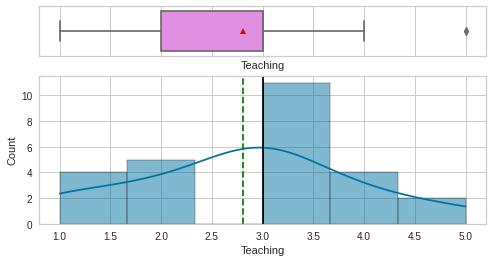

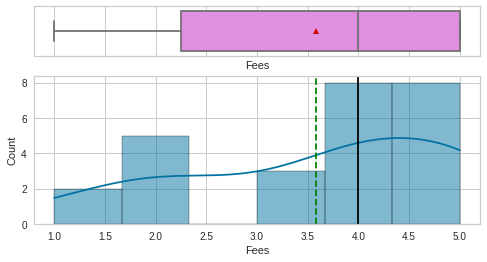

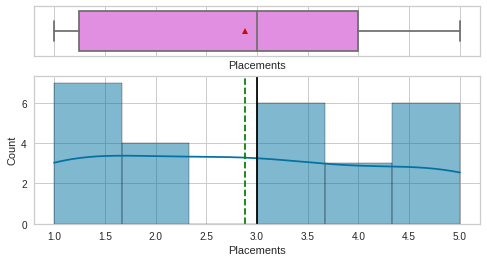

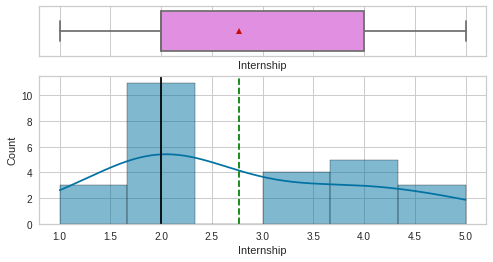

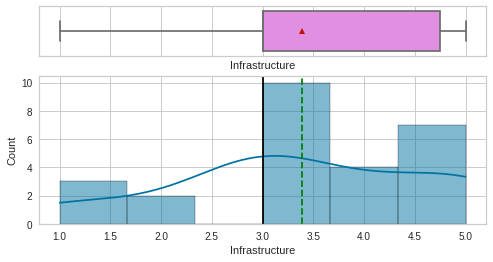

In [14]:
# selecting numerical columns
num_col = df.select_dtypes(include=np.number).columns.tolist()

for item in num_col:
    histogram_boxplot(df, item, kde=True, figsize=(8, 4))

**Observations**

- Fees in most of the colleges are high.
- At least 50% of the colleges have 2 as the rating for internship opportunities.

In [15]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

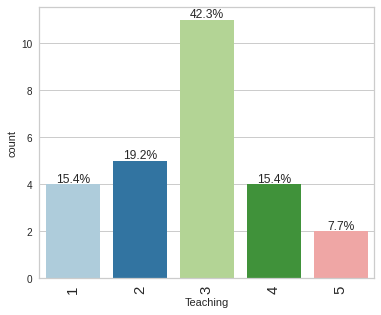

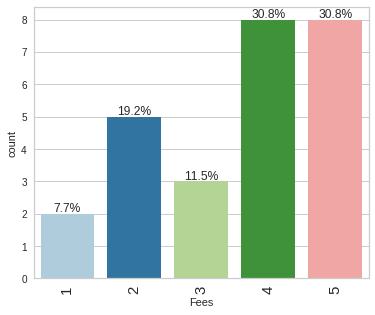

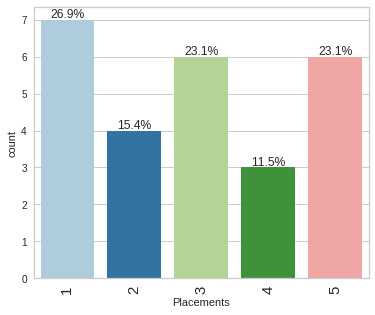

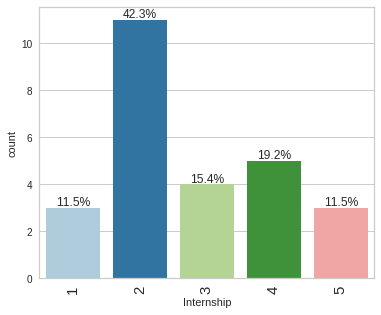

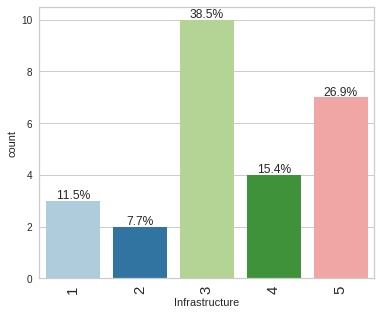

In [16]:
for item in num_col:
    labeled_barplot(df, item, perc=True)

**Observations**

- More than 75% of the colleges have a rating less than 4 for placements.
- More than 80% of the colleges have a rating of 3 or more for infrastructure.

### Bivariate Analsysis

**Let's check for correlations.**

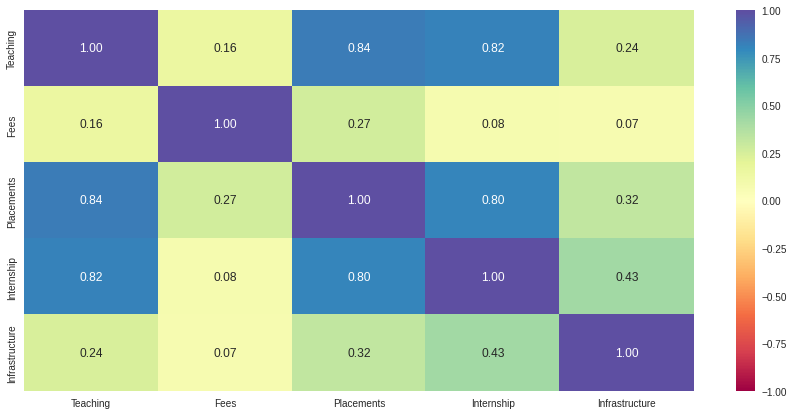

In [17]:
plt.figure(figsize=(15, 7))
sns.heatmap(df[num_col].corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

**Observation**

- Rating for teaching is strongly positively correlated with the rating for placements and internships.
- This is obvious because if teaching quality is high, students are more likely to get placements and internships.

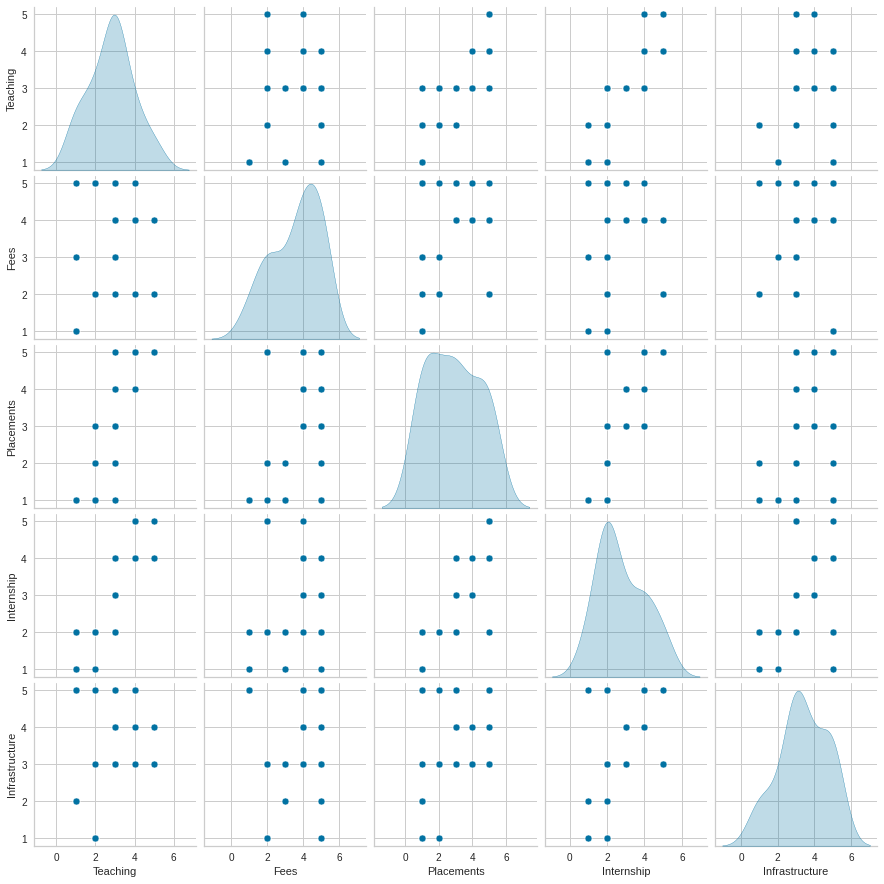

In [18]:
sns.pairplot(data=df[num_col], diag_kind="kde")
plt.show()

**Observations**

- Teaching is almost normally distributed.
- Distribution of fees seems to be bimodal.
- Distribution of Internships seems to be bimodal.

In [19]:
# Scaling the data set before clustering
scaler = StandardScaler()
subset = df[num_col].copy()
subset_scaled = scaler.fit_transform(subset)

In [20]:
# Creating a dataframe from the scaled data
subset_scaled_df = pd.DataFrame(subset_scaled, columns=subset.columns)

Number of Clusters: 1 	Average Distortion: 2.087990295998642
Number of Clusters: 2 	Average Distortion: 1.6030760049686552
Number of Clusters: 3 	Average Distortion: 1.3547610617306098
Number of Clusters: 4 	Average Distortion: 1.1658645562214658
Number of Clusters: 5 	Average Distortion: 1.0290612283501503
Number of Clusters: 6 	Average Distortion: 0.9095886756490557
Number of Clusters: 7 	Average Distortion: 0.8210830918162462
Number of Clusters: 8 	Average Distortion: 0.7072750736705818


Text(0.5, 1.0, 'Selecting k with the Elbow Method')

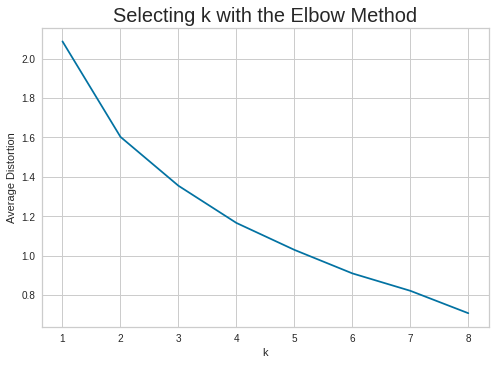

In [21]:
clusters = range(1, 9)
meanDistortions = []

for k in clusters:
    model = KMeans(n_clusters=k)
    model.fit(subset_scaled_df)
    prediction = model.predict(subset_scaled_df)
    distortion = (
        sum(
            np.min(cdist(subset_scaled_df, model.cluster_centers_, "euclidean"), axis=1)
        )
        / subset_scaled_df.shape[0]
    )

    meanDistortions.append(distortion)

    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")
plt.ylabel("Average Distortion")
plt.title("Selecting k with the Elbow Method", fontsize=20)

**The appropriate value of k from the elbow curve seems to be 4 or 5.**

**Let's check the silhouette scores.**

For n_clusters = 2, silhouette score is 0.3347415593639785
For n_clusters = 3, silhouette score is 0.2896589939792401
For n_clusters = 4, silhouette score is 0.3490226771698325
For n_clusters = 5, silhouette score is 0.32618685638156814
For n_clusters = 6, silhouette score is 0.3434990793023485
For n_clusters = 7, silhouette score is 0.40821763575055453
For n_clusters = 8, silhouette score is 0.3975512934421172
For n_clusters = 9, silhouette score is 0.3877165782852194


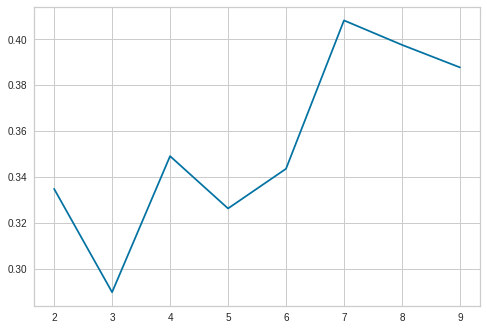

In [22]:
sil_score = []
cluster_list = list(range(2, 10))
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict((subset_scaled_df))
    # centers = clusterer.cluster_centers_
    score = silhouette_score(subset_scaled_df, preds)
    sil_score.append(score)
    print("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))

plt.plot(cluster_list, sil_score)

**From the silhouette scores, it seems that 7 is a good value of k.**

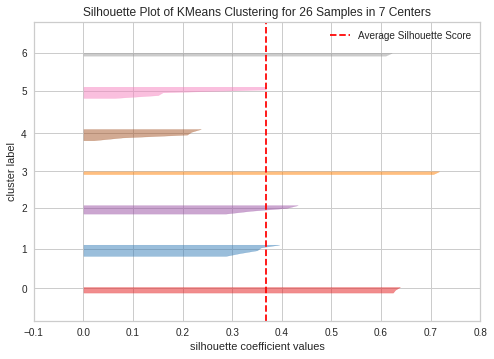

In [23]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(7, random_state=1))
visualizer.fit(subset_scaled_df)
visualizer.show()

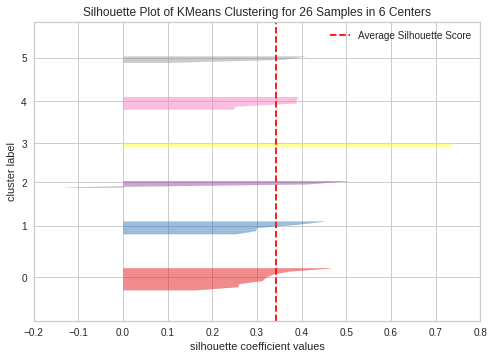

In [24]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(6, random_state=1))
visualizer.fit(subset_scaled_df)
visualizer.show()

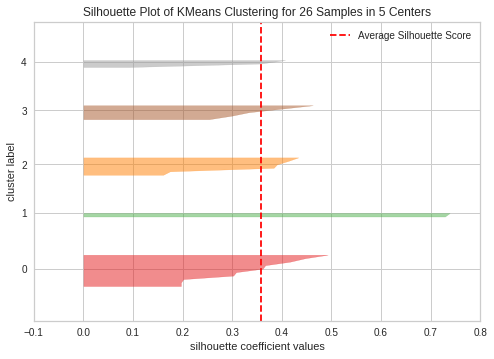

In [25]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(5, random_state=1))
visualizer.fit(subset_scaled_df)
visualizer.show()

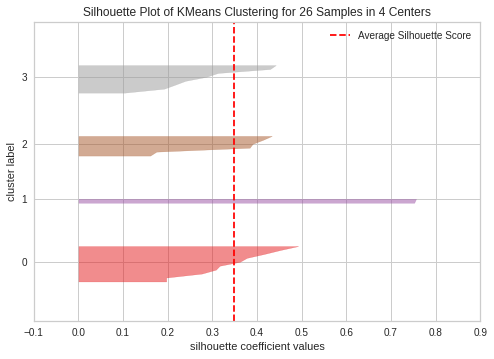

In [26]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(4, random_state=1))
visualizer.fit(subset_scaled_df)
visualizer.show()

**Let's take 5 as the appropriate no. of clusters as the silhouette score is high enough and there is knick at 5 in the elbow curve.**

In [27]:
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(subset_scaled_df)

KMeans(n_clusters=5, random_state=0)

In [28]:
# adding kmeans cluster labels to the original dataframe
df["K_means_segments"] = kmeans.labels_

In [29]:
cluster_profile = df.groupby("K_means_segments").mean()

In [30]:
cluster_profile["count_in_each_segment"] = (
    df.groupby("K_means_segments")["Fees"].count().values
)

In [31]:
# let's display cluster profiles
cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Teaching,Fees,Placements,Internship,Infrastructure,count_in_each_segment
K_means_segments,,,,,,
0,4.000000,3.625000,4.375000,4.375000,4.250000,8
1,1.333333,4.333333,1.000000,1.333333,1.666667,3
2,2.750000,4.625000,3.375000,2.500000,3.500000,8
3,1.000000,1.000000,1.000000,1.500000,5.000000,2
4,2.600000,2.400000,1.600000,2.000000,2.200000,5


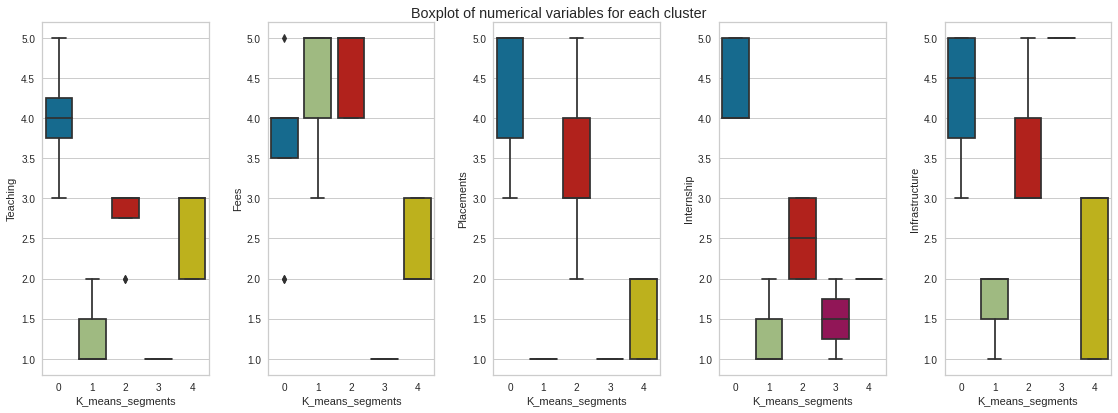

In [32]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of numerical variables for each cluster")
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii], y=df[num_col[counter]], x=df["K_means_segments"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

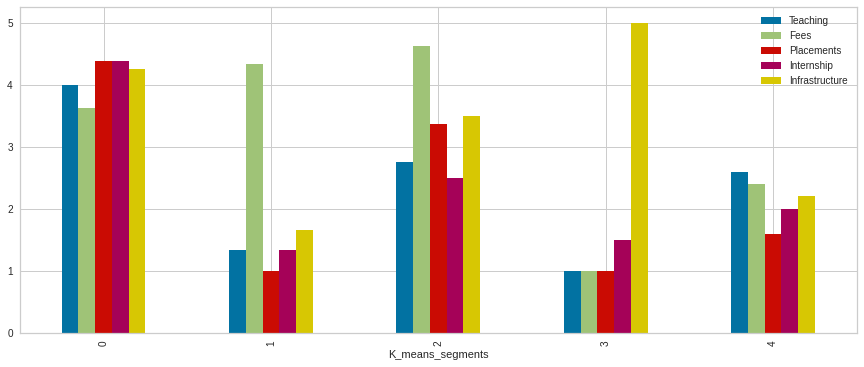

In [33]:
df.groupby("K_means_segments").mean().plot.bar(figsize=(15, 6))

### Insights

- **Cluster 0**:
    - Teaching ratings are moderate.
    - Fees range from high to very high for colleges in this cluster.
    - Placements ratings are moderate to high, with a few lows and very highs.
    - Internship ratings are low to moderate.
    - Infrastructure ratings are moderate to high, with a few very highs.


- **Cluster 1**:
    - Teaching ratings are moderate to high.
    - Fees are high for colleges in this cluster.
    - Placements ratings are moderate to very high.
    - Internship ratings are high.
    - Infrastructure ratings are high to very high.


- **Cluster 2**:
    - Teaching ratings are low to moderate.
    - Fees range from low to moderate for most colleges in this cluster.
    - Placements ratings are on the lower side.
    - Internship ratings are low.
    - Infrastructure ratings are very low to moderate.


- **Cluster 3**:
    - Teaching ratings are high.
    - Fees are low for colleges in this cluster.
    - Placements ratings are very high.
    - Internship ratings are very high.
    - Infrastructure ratings are moderate.


- **Cluster 4**:
    - Teaching ratings are very low.
    - Fees are very low for colleges in this cluster.
    - Placements ratings are very low.
    - Internship ratings are very low to low.
    - Infrastructure ratings are very high.

### Business Recommendations

- **Cluster 3**: These are the Tier 1 Colleges and have excellent teaching, placements & internships while maintaining a moderate infrastructure and low fees. **Corporates looking for the best candidates can approach this cluster for placements and internships.**


- **Cluster 1**: These are the Tier 2 Colleges which are just behind the Tier 1 colleges in terms of teaching and placements, but provide quite better infrastructure and are accordingly more expensive. **They have scope for improvements in teaching, placements, and internships, and should consider tie-ups with corporates and ed-tech and training organizations. Companies providing training programs to faculty and students should approach them.**


- **Cluster 0**: These are the Tier 3 colleges which have very high fees and very good infrastructure, but do not offer proper value-for-money in terms of teaching and internships. **This cluster of colleges will need to concentrate more towards onboarding better faculty and securing tie-ups with corporates to improve placement opportunities.**


- **Cluster 2** and **Cluster 4**: These are the poor performing colleges or new colleges. **These colleges will need to concentrate more on marketing and advertisements about their offerings to create awareness and attract students.**